In [10]:
import numpy as np

In [30]:
from PySDM.physics import constants as const
si = const.si

class Setup:
    nt = 100
    dt = 1 * si.s
    mass_of_dry_air = 1
    p0 = 1000 * si.hPa
    q0 = 0
    T0 = 300 * si.K
    w = lambda _: 1 * si.m / si.s
    z0 = 0
    n = np.zeros(0)
    volume = np.zeros(0)

setup = Setup()

In [31]:
from PySDM.particles import Particles
from PySDM.physics import formulae as phys
from PySDM.environments._moist import _Moist
from PySDM.environments._moist_lagrangian_parcel import _MoistLagrangianParcel
from PySDM.mesh import Mesh

const.g = 2


class MoistLagrangianParcelAdiabaticTITAN(_MoistLagrangianParcel):

    def __init__(self, particles: Particles, dt,
                 mass_of_dry_air: float, p0: float, q0: float, T0: float, w: callable, z0: float = 0):

        super().__init__(particles, dt, Mesh.mesh_0d(), ['rhod', 'z', 't'], mass_of_dry_air)

        # TODO: move w-related logic to _MoistLagrangianParcel
        self.w = w

        pd0 = p0 * (1 - (1 + const.eps / q0)**-1)

        self['qv'][:] = q0
        self['thd'][:] = phys.th_std(pd0, T0)
        self['rhod'][:] = pd0 / const.Rd / T0
        self['z'][:] = z0
        self['t'][:] = 0

        self.sync_parcel_vars()
        _Moist.sync(self)
        self.notify()

    def advance_parcel_vars(self):
        dt = self.particles.dt
        qv = self['qv'][0]
        T = self['T'][0]
        p = self['p'][0]
        t = self['t'][0]

        rho = p / phys.R(qv) / T
        pd = p * (1 - 1 / (1 + const.eps / qv))

        # mid-point value for w
        dz_dt = self.w(t + dt/2)

        # Explicit Euler for p,T (predictor step assuming dq=0)
        dp_dt = - rho * const.g * dz_dt
        dpd_dt = dp_dt  # dq=0
        dT_dt = dp_dt / rho / phys.c_p(qv)

        self._tmp['t'][:] += dt
        self._tmp['z'][:] += dt * dz_dt
        self._tmp['rhod'][:] += dt * (
                dpd_dt / const.Rd / T +
                -dT_dt * pd / const.Rd / T**2
        )

In [32]:
from PySDM.particles_builder import ParticlesBuilder
from PySDM.backends import Default
from PySDM.environments.products.pressure import Pressure



particles_builder = ParticlesBuilder(n_sd=0, backend=Default)
particles_builder.set_environment(MoistLagrangianParcelAdiabaticTITAN, {
            "dt": setup.dt,
            "mass_of_dry_air": setup.mass_of_dry_air,
            "p0": setup.p0,
            "q0": setup.q0,
            "T0": setup.T0,
            "w": setup.w,
            "z0": setup.z0
        })
attributes = {'n': setup.n, 'volume': setup.volume}
products = {Pressure: {}}
particles = particles_builder.get_particles(attributes, products)

ZeroDivisionError: float division by zero

In [27]:
p = [setup.p0]
for _ in range(setup.nt):
    particles.run(1)
    p.append(particles.products["p"].get())

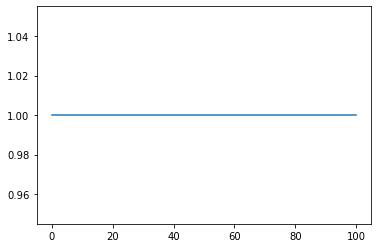

In [28]:
import matplotlib.pyplot as plt
plt.plot(p)